In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import json
import networkx as nx
from collections import defaultdict
import random
import matplotlib.pyplot as plt

c:\Users\baoqt\miniconda3\envs\311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
# Load the graph data from the JSON file
with open('Dataset/Graphs.JSON', 'r') as file:
    graph_data = json.load(file)

def analyze_graph_dataset(graph_data):
    # Extract all node types from graph_data
    node_types = []
    node_type_counts = defaultdict(int)
    
    for graph_item in graph_data:
        if "Graph" in graph_item:
            graph_info = graph_item["Graph"]
            if "Nodes" in graph_info:
                for node in graph_info["Nodes"]:
                    if "Properties" in node:
                        node_props = node["Properties"]
                        node_type = node_props.get("Type")
                        if node_type is not None:  # Skip null/None values
                            node_types.append(node_type)
                            node_type_counts[node_type] += 1
    
    # Get unique types
    unique_types = sorted(set(node_types))
    
    # Print results
    print(f"Found {len(unique_types)} unique node types across {len(node_types)} nodes")
    print("\nNode type distribution:")
    for node_type, count in sorted(node_type_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(node_types)) * 100
        print(f"{node_type}: {count} ({percentage:.1f}%)")
    
    # Automatically create node type to index mapping
    # Sort by frequency (most common types get lowest indices)
    node_type_to_idx = {}
    for idx, (node_type, _) in enumerate(sorted(node_type_counts.items(), key=lambda x: x[1], reverse=True)):
        node_type_to_idx[node_type] = idx
        
    print("\nGenerated node type mapping:")
    for node_type, idx in node_type_to_idx.items():
        print(f"'{node_type}': {idx}")
    
    # Now analyze the graph dataset for null types
    total_graphs = 0
    graphs_with_all_valid_nodes = 0
    graphs_with_some_null_nodes = 0
    graphs_with_all_null_nodes = 0

    # --- Added: Collect indices of graphs with any null node types ---
    indices_with_null_nodes = []
    
    for i, graph_item in enumerate(graph_data):
        if "Graph" in graph_item:
            total_graphs += 1
            graph_info = graph_item["Graph"]
            
            total_nodes = 0
            null_nodes = 0
            
            if "Nodes" in graph_info:
                for node in graph_info["Nodes"]:
                    if "Properties" in node:
                        total_nodes += 1
                        node_props = node["Properties"]
                        node_type = node_props.get("Type")
                        
                        if node_type is None or node_type not in node_type_to_idx:
                            null_nodes += 1
            # Analyze this graph based on node types
            if total_nodes == 0:
                graphs_with_all_null_nodes += 1
                indices_with_null_nodes.append(i)
            elif null_nodes == total_nodes:
                graphs_with_all_null_nodes += 1
                indices_with_null_nodes.append(i)
            elif null_nodes > 0:
                graphs_with_some_null_nodes += 1
                indices_with_null_nodes.append(i)
            else:
                graphs_with_all_valid_nodes += 1
    
    # Print results
    print(f"\nGraph Dataset Analysis:")
    print(f"Total graphs in dataset: {total_graphs}")
    print(f"Graphs with all valid nodes: {graphs_with_all_valid_nodes}")
    print(f"Graphs with some null node types: {graphs_with_some_null_nodes}")
    print(f"Graphs with all null node types: {graphs_with_all_null_nodes}")
    print(f"Graphs that would be removed: {len(indices_with_null_nodes)}")
    print(f"Remaining valid graphs: {total_graphs - len(indices_with_null_nodes)}")

    # --- Added: Remove all graphs with any null node types ---
    filtered_graph_data = [g for i, g in enumerate(graph_data) if i not in indices_with_null_nodes]
    print(f"\nFiltered out {len(graph_data) - len(filtered_graph_data)} graphs with null node types.")
    
    return unique_types, node_type_counts, node_type_to_idx, filtered_graph_data

# Analyze the node types in our dataset and filter graphs
unique_types, type_counts, node_type_to_idx, graph_data = analyze_graph_dataset(graph_data)

Found 4 unique node types across 481 nodes

Node type distribution:
Bed: 183 (38.0%)
Bath: 104 (21.6%)
Living: 100 (20.8%)
Circulation: 94 (19.5%)

Generated node type mapping:
'Bed': 0
'Bath': 1
'Living': 2
'Circulation': 3

Graph Dataset Analysis:
Total graphs in dataset: 100
Graphs with all valid nodes: 100
Graphs with some null node types: 0
Graphs with all null node types: 0
Graphs that would be removed: 0
Remaining valid graphs: 100

Filtered out 0 graphs with null node types.


Loaded 100 valid graphs
Unique node-edge count combinations: 5


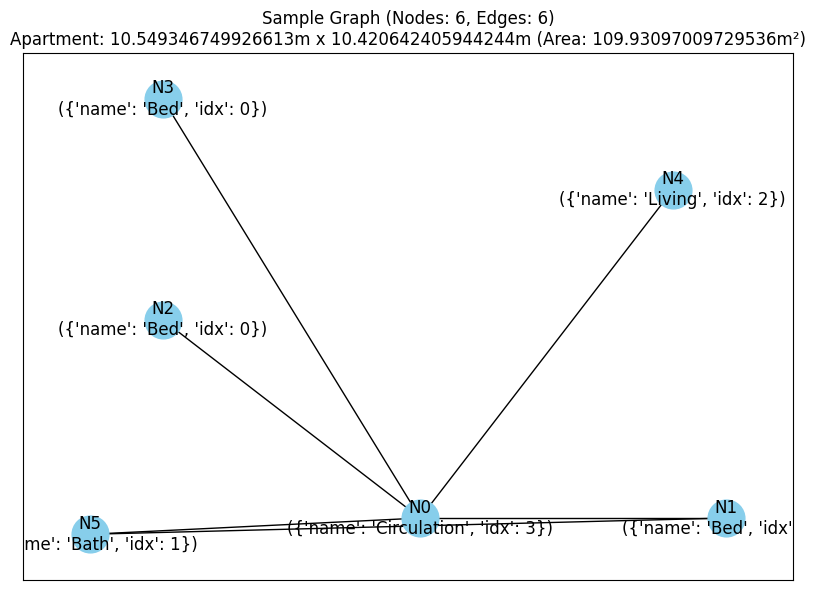


First Graph Details:
Apartment Dimensions: 10.549346749926613m x 10.420642405944244m
Apartment Area: 109.93097009729536m²
Program Vector: {'Bath': 1, 'Bed': 3, 'Circulation': 1, 'Living': 1}

Node Details:

Node N0:
  type: {'name': 'Circulation', 'idx': 3}
  x: 5.2245
  y: 1.9605
  apartment_width: 10.549346749926613
  apartment_length: 10.420642405944244
  apartment_area: 109.93097009729536
  program_vector: {'Bath': 1, 'Bed': 3, 'Circulation': 1, 'Living': 1}

Node N1:
  type: {'name': 'Bed', 'idx': 0}
  x: 8.389
  y: 1.9605
  apartment_width: 10.549346749926613
  apartment_length: 10.420642405944244
  apartment_area: 109.93097009729536
  program_vector: {'Bath': 1, 'Bed': 3, 'Circulation': 1, 'Living': 1}

Node N2:
  type: {'name': 'Bed', 'idx': 0}
  x: 2.562
  y: 5.1075
  apartment_width: 10.549346749926613
  apartment_length: 10.420642405944244
  apartment_area: 109.93097009729536
  program_vector: {'Bath': 1, 'Bed': 3, 'Circulation': 1, 'Living': 1}

Node N3:
  type: {'name': '

In [3]:
# Process the graphs
graph_list = []
node_edge_counts = defaultdict(list)

for graph_item in graph_data:  # Each item in the list is a graph
    if "Graph" in graph_item:
        graph_info = graph_item["Graph"]
        
        # Create a new graph
        G = nx.Graph()
        
        # Extract apartment dimensions from Graph properties
        apartment_width = graph_info.get("Attributes", {}).get("Width", 7)  # default 7 if not found
        apartment_length = graph_info.get("Attributes", {}).get("Length", 10)  # default 10 if not found
        apartment_area = apartment_width * apartment_length  # Calculate area
        
        # First pass: Count room types in this specific graph
        temp_counts = defaultdict(int)
        if "Nodes" in graph_info:
            for node in graph_info["Nodes"]:
                if "Properties" in node:
                    node_type = node["Properties"].get("Type")
                    if node_type is not None:
                        temp_counts[node_type] += 1
        
        # Create ordered program vector based on unique_types
        program_vector = {room_type: temp_counts.get(room_type, 0) for room_type in unique_types}
        
        # Add dimensions, area and program vector to graph attributes
        G.graph['width'] = apartment_width
        G.graph['length'] = apartment_length
        G.graph['area'] = apartment_area
        G.graph['program_vector'] = program_vector
        
        # Second pass: Add nodes with awareness of all room counts
        if "Nodes" in graph_info:
            for node in graph_info["Nodes"]:
                if "Properties" in node:
                    node_props = node["Properties"]
                    node_id = node_props.get("Id")
                    node_type = node_props.get("Type")
                    if node_id is not None and node_type is not None:
                        # Store node properties
                        G.add_node(node_id, 
                                 type={'name': node_type, 
                                      'idx': node_type_to_idx[node_type]},
                                 x=node_props.get("Point", {}).get("X"),
                                 y=node_props.get("Point", {}).get("Y"),
                                 apartment_width=apartment_width,
                                 apartment_length=apartment_length,
                                 apartment_area=apartment_area,
                                 program_vector=program_vector)
        # Process edges and add edge length as an attribute
        if "Edges" in graph_info:
            for edge in graph_info["Edges"]:
                if "Properties" in edge:
                    edge_props = edge["Properties"]
                    source_id = edge_props.get("SourceId")
                    target_id = edge_props.get("TargetId")
                    # Try to get edge length from properties, else compute from node positions
                    edge_length = edge_props.get("Length")
                    if edge_length is None and source_id is not None and target_id is not None:
                        # Compute Euclidean distance if not provided
                        try:
                            src = G.nodes[source_id]
                            tgt = G.nodes[target_id]
                            edge_length = ((src['x'] - tgt['x']) ** 2 + (src['y'] - tgt['y']) ** 2) ** 0.5
                        except Exception:
                            edge_length = 0.0
                    if source_id is not None and target_id is not None:
                        G.add_edge(source_id, target_id, length=edge_length)
        
        if len(G.nodes) > 0:  # Only add non-empty graphs
            graph_list.append(G)
            node_edge_counts[(len(G.nodes), len(G.edges))].append(G)

print(f"Loaded {len(graph_list)} valid graphs")
print(f"Unique node-edge count combinations: {len(node_edge_counts)}")

graph_index = 1  # Index of the graph you want to inspect

# Plot one example graph with node types (unchanged)
if graph_list:
    plt.figure(figsize=(8, 6))
    sample_graph = graph_list[graph_index]
    
    pos = {node: (data.get('x', 0), data.get('y', 0)) 
           for node, data in sample_graph.nodes(data=True)}
    
    nx.draw_networkx_nodes(sample_graph, pos, 
                          node_color='skyblue',
                          node_size=700)
    
    nx.draw_networkx_edges(sample_graph, pos)
    
    labels = {node: f"{node}\n({data.get('type', 'unknown')})" 
             for node, data in sample_graph.nodes(data=True)}
    nx.draw_networkx_labels(sample_graph, pos, labels)
    
    plt.title(f"Sample Graph (Nodes: {len(sample_graph.nodes)}, Edges: {len(sample_graph.edges)})\n"
              f"Apartment: {sample_graph.graph['width']}m x {sample_graph.graph['length']}m (Area: {sample_graph.graph['area']}m²)")
    plt.tight_layout()
    plt.show()

# Print details of the first graph
if graph_list:
    sample_graph = graph_list[graph_index]
    print("\nFirst Graph Details:")
    print(f"Apartment Dimensions: {sample_graph.graph['width']}m x {sample_graph.graph['length']}m")
    print(f"Apartment Area: {sample_graph.graph['area']}m²")
    print(f"Program Vector: {sample_graph.graph['program_vector']}")
    print("\nNode Details:")
    for node, data in sample_graph.nodes(data=True):
        print(f"\nNode {node}:")
        for key, value in data.items():
            print(f"  {key}: {value}")
    print("\nEdge Details:")
    for u, v, data in sample_graph.edges(data=True):
        print(f"Edge {u}-{v}: length={data.get('length', 'N/A')}")

In [4]:

# Two-way conversion functions
def type_to_int(node_type):
    """Convert a node type string to its integer representation
    
    Args:
        node_type (str): The node type as a string (e.g., 'Bed')
        
    Returns:
        int: The integer code for the node type, or -1 if not found
    """
    # Handle case where node_type is None
    if not node_type:
        return -1
        
    # Return the integer code or -1 if not found
    return node_type_to_idx.get(node_type, -1)

def int_to_type(type_code):
    """Convert an integer node type code back to its string representation
    
    Args:
        type_code (int): The integer code for the node type
        
    Returns:
        str: The node type as a string, or 'unknown' if not found
    """
    # Create reverse mapping
    idx_to_type = {v: k for k, v in node_type_to_idx.items()}
    # Return the node type string or 'unknown' if not found
    return idx_to_type.get(type_code, 'unknown')

In [5]:
import torch.nn.functional as F

def convert_nx_to_pyg(graph, unique_types):
    """
    Convert a NetworkX graph to a PyTorch Geometric Data object.

    Args:
        graph: NetworkX graph.
        unique_types: List of unique node types for one-hot encoding.

    Returns:
        PyTorch Geometric Data object or None if conversion fails.
    """
    try:
        # Extract node features: type idx, x, y, width, length, area, program vector
        x = []
        for node, data in graph.nodes(data=True):
            if 'type' not in data or not isinstance(data['type'], dict) or 'idx' not in data['type']:
                continue

            node_type_idx = data['type']['idx']
            node_x = data['x']
            node_y = data['y']
            width = graph.graph['width']
            length = graph.graph['length']
            area = graph.graph['area']
            program_vector = list(graph.graph['program_vector'].values())

            # Combine all features into a single vector
            one_hot = F.one_hot(torch.tensor(node_type_idx), num_classes=len(unique_types)).tolist()
            features = one_hot + [node_x, node_y, width, length, area] + program_vector
            x.append(features)

        if not x:
            return None

        x_tensor = torch.tensor(x, dtype=torch.float)

        # Build edge_index and edge_attr (edge length)
        edge_index = []
        edge_attr = []
        node_id_to_idx = {node: idx for idx, node in enumerate(graph.nodes())}
        for source, target, edge_data in graph.edges(data=True):
            if source in node_id_to_idx and target in node_id_to_idx:
                idx_u = node_id_to_idx[source]
                idx_v = node_id_to_idx[target]
                edge_index.append([idx_u, idx_v])
                edge_index.append([idx_v, idx_u])  # undirected

                # Edge length from edge properties
                length_val = edge_data.get('length', 0.0)
                edge_attr.append([length_val])
                edge_attr.append([length_val])  # undirected

        if len(edge_index) > 0:
            edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t()
            edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)
            data_obj = Data(
                # Node features
                x=x_tensor,
                edge_index=edge_index_tensor,
                edge_attr=edge_attr_tensor,
                # Additional graph-level attributes
                area=torch.tensor([graph.graph['area']], dtype=torch.float),
                apartment_width=torch.tensor([graph.graph['width']], dtype=torch.float),
                apartment_length=torch.tensor([graph.graph['length']], dtype=torch.float),
                program_vector=torch.tensor([list(graph.graph['program_vector'].values())], dtype=torch.float)
            )
            return data_obj
    except Exception as e:
        print(f"Failed to process graph: {str(e)}")
        return None

In [6]:
# Define type encoding maps for consistency
type_encodings = node_type_to_idx
reverse_encodings = {idx: name for name, idx in node_type_to_idx.items()}

# Convert all graphs in graph_list to PyTorch Geometric Data objects
processed_graphs = []
for i, graph in enumerate(graph_list):
    data_obj = convert_nx_to_pyg(graph, unique_types)
    if data_obj is not None:
        processed_graphs.append(data_obj)

print(f"Converted {len(processed_graphs)} graphs to PyTorch Geometric Data objects.")

# Print summary and shape of node and edge tensors for a chosen graph
if processed_graphs:
    print(f"Total processed graphs: {len(processed_graphs)}")
    print(f"Node feature dimension: {processed_graphs[0].x.shape[1]}")
    chosen_index = 3 if len(processed_graphs) > 3 else 0
    print(f"Graph {chosen_index} node tensor shape: {processed_graphs[chosen_index].x.shape}")
    print(f"Graph {chosen_index} edge_index shape: {processed_graphs[chosen_index].edge_index.shape}")
    print(f"Graph {chosen_index} edge_attr shape: {processed_graphs[chosen_index].edge_attr.shape}")

Converted 100 graphs to PyTorch Geometric Data objects.
Total processed graphs: 100
Node feature dimension: 13
Graph 3 node tensor shape: torch.Size([4, 13])
Graph 3 edge_index shape: torch.Size([2, 8])
Graph 3 edge_attr shape: torch.Size([8, 1])


In [7]:
print(type_encodings)

{'Bed': 0, 'Bath': 1, 'Living': 2, 'Circulation': 3}


In [8]:
print (processed_graphs[3])

Data(x=[4, 13], edge_index=[2, 8], edge_attr=[8, 1], area=[1], apartment_width=[1], apartment_length=[1], program_vector=[1, 4])


In [9]:
# Let's take a graph node and print its tensor representation
# Let's choose a graph from our list
sample_graph_index = 12  
sample_graph = graph_list[sample_graph_index]

import numpy as np

def get_node_type(features):
    one_hot = features[:len(type_encodings)]
    type_code = int(np.argmax(one_hot))
    return reverse_encodings.get(type_code, 'unknown')

# Find the corresponding processed PyG graph
processed_graph = processed_graphs[sample_graph_index]

print(f"Graph {sample_graph_index} Details:")
print(f"Original graph: {len(sample_graph.nodes)} nodes, {len(sample_graph.edges)} edges")
print(f"PyG graph: {processed_graph.num_nodes} nodes, {processed_graph.num_edges//2} edges")
print("\nNode Data:")

# Display each node in the graph and its tensor representation
for i, (node, data) in enumerate(sample_graph.nodes(data=True)):
    # Print original node data
    print(f"\nNode {node}:")
    print(f"  Type: {data['type']}")
    print(f"  Position: ({data['x']:.2f}, {data['y']:.2f})")
    
    # Print corresponding tensor representation
    if i < processed_graph.num_nodes:
        tensor_repr = processed_graph.x[i]
        print(f"  Tensor representation: {tensor_repr}")
        print(f"  - Normalized X: {tensor_repr[0]:.4f}")
        print(f"  - Normalized Y: {tensor_repr[1]:.4f}")
        print(f"  - Type encoding: {int(tensor_repr[2])}")
        print(f"  - Type decoded: {get_node_type(tensor_repr.tolist())}")

Graph 12 Details:
Original graph: 5 nodes, 5 edges
PyG graph: 5 nodes, 5 edges

Node Data:

Node N0:
  Type: {'name': 'Circulation', 'idx': 3}
  Position: (3.91, 3.23)
  Tensor representation: tensor([ 0.0000,  0.0000,  0.0000,  1.0000,  3.9120,  3.2345,  8.3461, 10.6837,
        89.1676,  1.0000,  2.0000,  1.0000,  1.0000])
  - Normalized X: 0.0000
  - Normalized Y: 0.0000
  - Type encoding: 0
  - Type decoded: Circulation

Node N1:
  Type: {'name': 'Bed', 'idx': 0}
  Position: (1.62, 1.47)
  Tensor representation: tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  1.6170,  1.4705,  8.3461, 10.6837,
        89.1676,  1.0000,  2.0000,  1.0000,  1.0000])
  - Normalized X: 1.0000
  - Normalized Y: 0.0000
  - Type encoding: 0
  - Type decoded: Bed

Node N2:
  Type: {'name': 'Bed', 'idx': 0}
  Position: (6.47, 2.16)
  Tensor representation: tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  6.4680,  2.1565,  8.3461, 10.6837,
        89.1676,  1.0000,  2.0000,  1.0000,  1.0000])
  - Normalized X: 1.000

# Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import json
import networkx as nx
from collections import defaultdict
import random
import matplotlib.pyplot as plt

# Negative sampling function implementation
def negative_sampling(edge_index, num_nodes, num_neg_samples=None):
    """Generate negative samples by creating random edges that don't exist in the graph."""
    # If num_neg_samples not specified, use same number as positive edges
    num_neg_samples = num_neg_samples or edge_index.size(1)
    
    # Create all possible edges as a 2D tensor
    all_edges = set()
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:  # Exclude self-loops
                all_edges.add((i, j))
    
    # Remove existing edges
    existing_edges = set(tuple(e) for e in edge_index.t().tolist())
    candidate_edges = list(all_edges - existing_edges)
    
    # Randomly select negative edges
    if len(candidate_edges) <= num_neg_samples:
        neg_edges = candidate_edges  # If not enough candidates, use all
    else:
        neg_edges = random.sample(candidate_edges, num_neg_samples)
    
    # Convert to tensor
    neg_edge_index = torch.tensor(neg_edges, dtype=torch.long).t()
    
    # Ensure we're on the same device as the input
    return neg_edge_index.to(edge_index.device)

class GraphGenerator(nn.Module):
    def __init__(self, node_features, hidden_dim=64):
        super(GraphGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Ensure input features are handled correctly
        self.conv1 = GATConv(node_features, hidden_dim, heads=1)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1)
        
        # Node prediction layers
        self.node_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_features)  # Output should match input features
        )
        
        # Edge prediction layer
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def encode(self, x, edge_index):
        # Apply convolutions with ReLU and dropout between layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        return x

    def decode_edges(self, z, edge_index, edge_attr=None):
        row, col = edge_index
        edge_features = torch.cat([z[row], z[col]], dim=1)
        if edge_attr is not None:
            edge_features = torch.cat([edge_features, edge_attr], dim=1)
        return self.edge_predictor(edge_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Encode the graph
        z = self.encode(x, edge_index)
        
        # Predict new node features
        new_node_features = self.node_predictor(z)
        
        # Predict edge probabilities
        edge_pred = self.decode_edges(z, edge_index)
        
        return new_node_features, edge_pred

# Train

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader

# Hyperparameters
num_epochs = 100
learning_rate = 0.001
batch_size = 32
hidden_dim = 64

# Create DataLoader
train_loader = DataLoader(processed_graphs, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, and loss function
model = GraphGenerator(node_features=processed_graphs[0].x.shape[1], hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()  # Assuming binary classification for edge prediction

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        new_node_features, edge_pred = model(data)

        # create binary labels for existing edges
        edge_labels = torch.ones(edge_pred.shape, device=edge_pred.device)
        loss = criterion(edge_pred, edge_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}')

# Save the trained model
torch.save(model.state_dict(), 'graph_generator_model.pth')

Epoch 1/100, Loss: 0.7025
Epoch 2/100, Loss: 0.0775
Epoch 3/100, Loss: 0.0136


c:\Users\baoqt\miniconda3\envs\311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 4/100, Loss: 0.0032
Epoch 5/100, Loss: 0.0011
Epoch 6/100, Loss: 0.0005
Epoch 7/100, Loss: 0.0003
Epoch 8/100, Loss: 0.0002
Epoch 9/100, Loss: 0.0003
Epoch 10/100, Loss: 0.0002
Epoch 11/100, Loss: 0.0001
Epoch 12/100, Loss: 0.0001
Epoch 13/100, Loss: 0.0000
Epoch 14/100, Loss: 0.0001
Epoch 15/100, Loss: 0.0001
Epoch 16/100, Loss: 0.0000
Epoch 17/100, Loss: 0.0000
Epoch 18/100, Loss: 0.0000
Epoch 19/100, Loss: 0.0000
Epoch 20/100, Loss: 0.0000
Epoch 21/100, Loss: 0.0001
Epoch 22/100, Loss: 0.0000
Epoch 23/100, Loss: 0.0001
Epoch 24/100, Loss: 0.0000
Epoch 25/100, Loss: 0.0001
Epoch 26/100, Loss: 0.0000
Epoch 27/100, Loss: 0.0000
Epoch 28/100, Loss: 0.0000
Epoch 29/100, Loss: 0.0001
Epoch 30/100, Loss: 0.0000
Epoch 31/100, Loss: 0.0001
Epoch 32/100, Loss: 0.0000
Epoch 33/100, Loss: 0.0000
Epoch 34/100, Loss: 0.0000
Epoch 35/100, Loss: 0.0001
Epoch 36/100, Loss: 0.0000
Epoch 37/100, Loss: 0.0000
Epoch 38/100, Loss: 0.0001
Epoch 39/100, Loss: 0.0000
Epoch 40/100, Loss: 0.0000
Epoch 4

# Eval

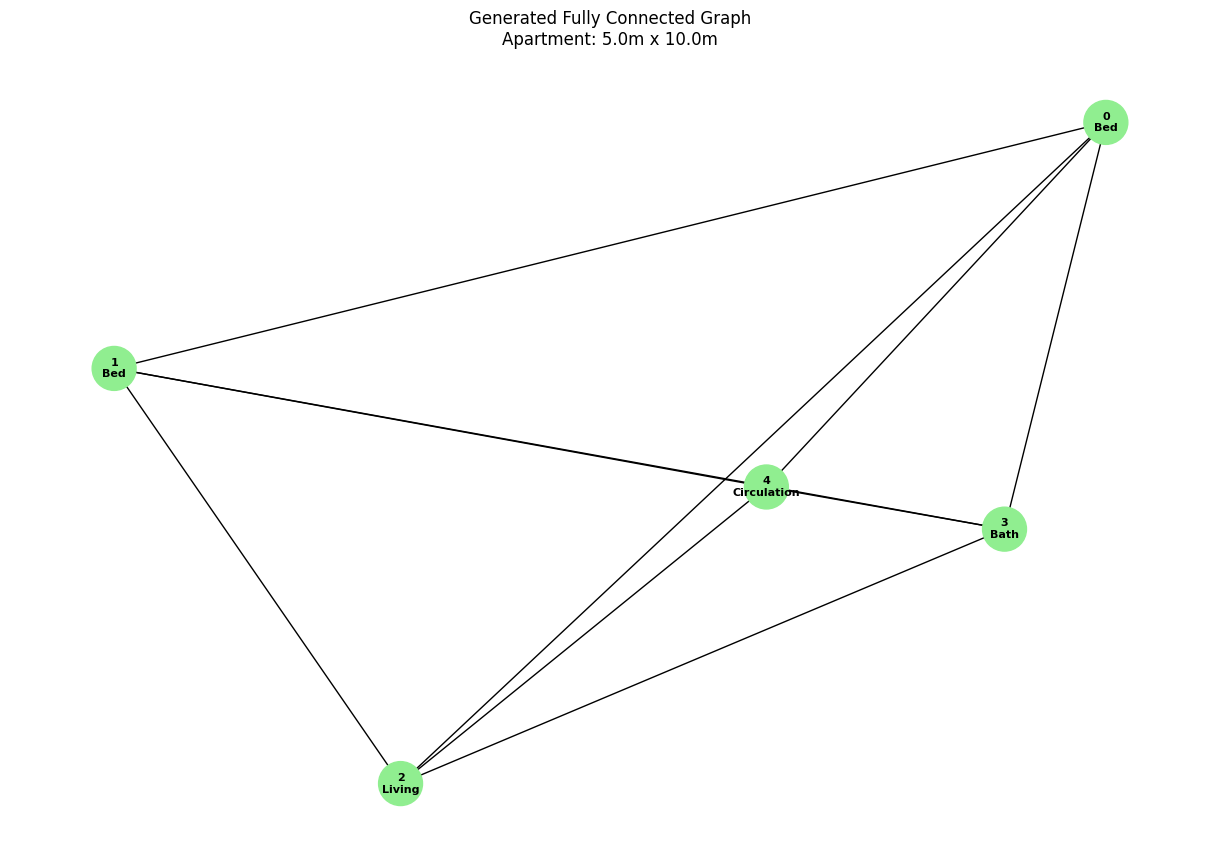


Graph Statistics:
Total nodes: 5
Total edges: 10

Node Types:
Node 0: Bed (Required)
Node 1: Bed (Required)
Node 2: Living (Required)
Node 3: Bath (Required)
Node 4: Circulation (Required)


In [17]:
def generate_new_graph(model, required_nodes, apartment_width, apartment_length, num_additional_nodes):
    """
    Generate a fully connected graph with specified node requirements.

    Args:
        model: Trained GraphGenerator model
        required_nodes: Dict[str, int] - Dictionary of required node types and their counts
        apartment_width: float - Width of the apartment
        apartment_length: float - Length of the apartment
        num_additional_nodes: int - Number of additional nodes to generate freely
    """
    device = next(model.parameters()).device  # Get the device the model is on
    model.eval()
    with torch.no_grad():
        # Calculate total number of nodes
        num_fixed_nodes = sum(required_nodes.values())
        total_nodes = num_fixed_nodes + num_additional_nodes

        # Prepare program vector (all zeros, can be customized)
        program_vector = [0] * len(type_encodings)

        # Build node features to match training dimension
        node_features = []
        for node_type, count in required_nodes.items():
            type_code = type_encodings[node_type]
            for _ in range(count):
                x_coord = float(torch.rand(1, device=device))
                y_coord = float(torch.rand(1, device=device))
                one_hot = [0] * len(type_encodings)
                one_hot[type_code] = 1
                features = (
                    one_hot
                    + [x_coord, y_coord]
                    + [apartment_width, apartment_length, apartment_width * apartment_length]
                    + program_vector
                )
                node_features.append(features)

        # Additional nodes (random types)
        available_types = list(type_encodings.keys())
        for _ in range(num_additional_nodes):
            selected_type = random.choice(available_types)
            type_code = type_encodings[selected_type]
            x_coord = float(torch.rand(1, device=device))
            y_coord = float(torch.rand(1, device=device))
            one_hot = [0] * len(type_encodings)
            one_hot[type_code] = 1
            features = (
                one_hot
                + [x_coord, y_coord]
                + [apartment_width, apartment_length, apartment_width * apartment_length]
                + program_vector
            )
            node_features.append(features)

        x = torch.tensor(node_features, dtype=torch.float).to(device)

        # Create NetworkX graph for visualization
        G = nx.Graph()
        for i in range(total_nodes):
            features = x[i].cpu().numpy()
            node_type = get_node_type(features)
            G.add_node(i,
                       type=node_type,
                       position=(features[len(type_encodings)], features[len(type_encodings)+1]),
                       fixed=(i < num_fixed_nodes))

        # Add edges to make the graph fully connected
        for i in range(total_nodes):
            for j in range(i + 1, total_nodes):
                G.add_edge(i, j)

        # Visualize the graph
        plt.figure(figsize=(12, 8))
        pos = {i: (G.nodes[i]['position'][0], G.nodes[i]['position'][1]) for i in G.nodes()}
        node_colors = ['lightgreen' if G.nodes[n]['fixed'] else 'lightblue' for n in G.nodes()]
        node_labels = {n: f"{n}\n{G.nodes[n]['type']}" for n in G.nodes()}

        nx.draw(G, pos=pos,
                with_labels=True,
                node_color=node_colors,
                node_size=1000,
                font_size=8,
                font_weight='bold',
                labels=node_labels)

        plt.title(f"Generated Fully Connected Graph\nApartment: {apartment_width}m x {apartment_length}m")
        plt.show()

        # Print node and edge statistics
        print("\nGraph Statistics:")
        print(f"Total nodes: {G.number_of_nodes()}")
        print(f"Total edges: {G.number_of_edges()}")
        print("\nNode Types:")
        for node, attr in G.nodes(data=True):
            print(f"Node {node}: {attr['type']} ({'Required' if attr['fixed'] else 'Generated'})")

        return G

# Example usage with specific apartment dimensions
required_nodes = {
    'Bed': 2,
    'Living': 1,
    'Bath': 1,
    'Circulation': 1
}

apartment_width = 5.0  # meters
apartment_length = 10.0  # meters
num_additional_nodes = 0  # Additional rooms to generate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate new fully connected graph
new_graph = generate_new_graph(
    model=model,
    required_nodes=required_nodes,
    apartment_width=apartment_width,
    apartment_length=apartment_length,
    num_additional_nodes=num_additional_nodes
)

In [18]:
# Fix for device mismatch in predict_and_visualize_edges_new_graph
def predict_and_visualize_edges_new_graph(model, nx_graph):
    """
    Predict, classify, and visualize edges for the newly generated graph.

    Args:
        model: Trained GraphGenerator model.
        nx_graph: NetworkX graph.

    Returns:
        updated_graph: NetworkX graph with corrected edges.
    """
    # Convert NetworkX graph to PyTorch Geometric Data object
    graph_data = convert_nx_to_pyg(nx_graph)

    # Ensure the model and data are on the same device
    device = next(model.parameters()).device
    graph_data.x = graph_data.x.to(device)
    graph_data.edge_index = graph_data.edge_index.to(device)

    model.eval()
    with torch.no_grad():
        # Encode the graph to get node embeddings
        z = model.encode(graph_data.x, graph_data.edge_index)

        # Predict edge probabilities
        edge_pred = model.decode_edges(z, graph_data.edge_index)

        # Classify edges based on a threshold (e.g., 0.5)
        edge_classes = (edge_pred > 0.5).long()

        # Print results
        print("\nEdge Predictions:")
        for i, (prob, cls) in enumerate(zip(edge_pred, edge_classes)):
            print(f"Edge {i}: Probability = {prob.item():.4f}, Class = {cls.item()}")

        # Create a new NetworkX graph with corrected edges
        updated_graph = nx.Graph()
        for i, data in nx_graph.nodes(data=True):
            updated_graph.add_node(i, **data)

        edge_index = graph_data.edge_index.cpu().numpy()
        for i, (u, v) in enumerate(zip(edge_index[0], edge_index[1])):
            if edge_classes[i].item() == 1:  # Add edge if classified as existing
                updated_graph.add_edge(u, v)

        # Visualize the updated graph
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(updated_graph)  # Use spring layout for visualization
        nx.draw(updated_graph, pos, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
        plt.title("Graph with Corrected Edges")
        plt.show()

        return updated_graph

# Example usage
corrected_graph = predict_and_visualize_edges_new_graph(model, new_graph)

TypeError: convert_nx_to_pyg() missing 1 required positional argument: 'unique_types'